In [2]:
# ===================================
# CNN Evaluation Pipeline
# ===================================

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
import seaborn as sn

In [15]:
# ------------------------------
# CONFIG
# ------------------------------
MODEL_PATH = "cnn_lung_model.keras"
DATA_DIR = "lung_image_sets"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CLASS_NAMES = ['lung_aca', 'lung_n', 'lung_scc']

In [16]:
# ------------------------------
# LOAD MODEL
# ------------------------------
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ CNN model loaded successfully.")

✅ CNN model loaded successfully.


In [17]:
# ------------------------------
# TEST DATA - categorical for ROC
# ------------------------------
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    return tf.cast(image, tf.float32) / 255.0, label


In [18]:
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


In [19]:
class_names = raw_test_ds.class_names
NUM_CLASSES = len(class_names)
test_ds = raw_test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)


In [20]:
# ------------------------------
# PREDICTIONS
# ------------------------------
y_true_bin = []
y_score = []


In [21]:
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_score.extend(preds)
    y_true_bin.extend(labels.numpy())

y_true_bin = np.array(y_true_bin)
y_score = np.array(y_score)
y_pred = np.argmax(y_score, axis=1)
y_true = np.argmax(y_true_bin, axis=1)

In [22]:
# ------------------------------
# METRICS & REPORT
# ------------------------------
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

acc = accuracy_score(y_true, y_pred)
print(f"✅ Overall Accuracy: {acc * 100:.2f}%")



📋 Classification Report:
              precision    recall  f1-score   support

    lung_aca       0.99      0.99      0.99      1017
      lung_n       1.00      1.00      1.00       987
    lung_scc       0.99      0.99      0.99       996

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

✅ Overall Accuracy: 99.37%


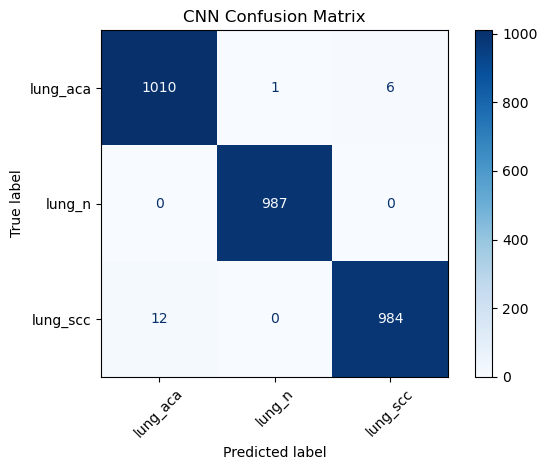

In [23]:
# ------------------------------
# CONFUSION MATRIX
# ------------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("CNN Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


In [24]:
# ------------------------------
# PER-CLASS ACCURACY
# ------------------------------
correct = cm.diagonal()
total = cm.sum(axis=1)
class_acc = correct / total

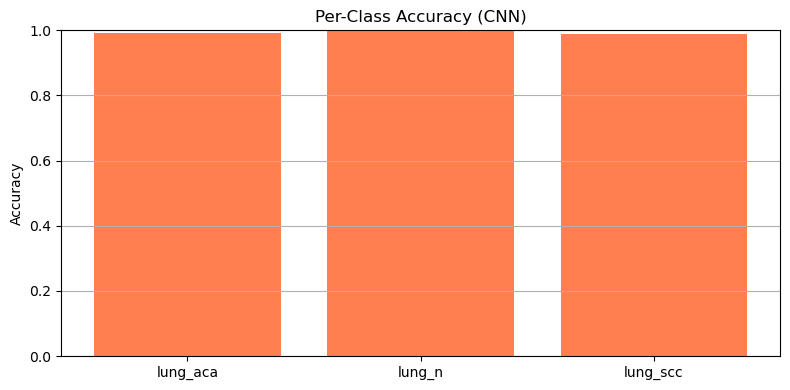

In [25]:
plt.figure(figsize=(8, 4))
plt.bar(class_names, class_acc, color='coral')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy (CNN)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


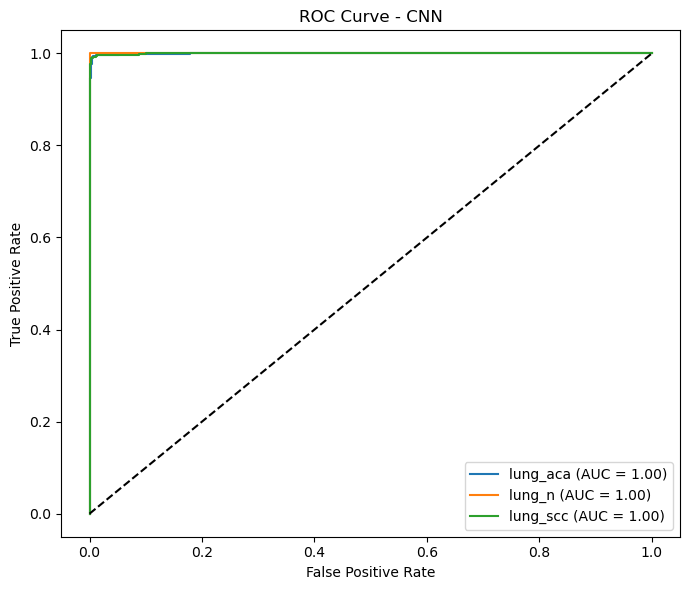

In [26]:
# -------------------------------
# ROC CURVE
# -------------------------------
y_true_bin = label_binarize(y_true, classes=range(len(CLASS_NAMES)))
plt.figure(figsize=(7, 6))

for i in range(len(CLASS_NAMES)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CLASS_NAMES[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CNN")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()